In [1363]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
from scipy.stats import describe, expon, norm, t, uniform
from sklearn.base import clone
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge, RidgeCV
from sklearn.metrics import (
    make_scorer, mean_absolute_error as mae, mean_squared_error
)
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler,
    quantile_transform, QuantileTransformer
)

In [1364]:
sns.set_theme(palette='tab10')
warnings.filterwarnings('ignore')

**Содержание**<a id='toc0_'></a>    
- [__Простейшая линейная регрессия__](#toc1_1_)    
  - [__Модель простейшей линейной регрессии и метод наименьших квадратов (МНК)__](#toc1_1_1_)    
  - [__Оценки параметров линейной регрессии и их свойства__](#toc1_1_2_)    
  - [__Доверительные интервалы для коэффициентов регрессии__](#toc1_1_3_)    
  - [__Гипотеза о статистической значимости параметров линейной регрессии__](#toc1_1_4_)    
- [__Множественная линейная регрессия__](#toc1_2_)    
  - [__Определения и матричные обозначения__](#toc1_2_1_)    
  - [__МНК для множественной регрессии__](#toc1_2_2_)    
- [__Работа с признаками__](#toc1_3_)    
  - [__One-hot encoding__](#toc1_3_1_)    
  - [__Bag of words__](#toc1_3_2_)    
  - [__Бинаризация числовых признаков__](#toc1_3_3_)    
  - [__Масштабирование__](#toc1_3_4_)    
- [__Измерение ошибки в задачах регрессии__](#toc1_4_)    
  - [__Функционалы ошибок RSE, RMSE, MSE__](#toc1_4_1_)    
  - [__Коэффициент детерминации R2__](#toc1_4_2_)    
  - [__MAE__](#toc1_4_3_)    
  - [__MAPE, SMAPE__](#toc1_4_4_)    
  - [__Adjusted R2, AIC__](#toc1_4_5_)    
- [__Обучение линейной регрессии__](#toc1_5_)    
  - [__Ключевые понятия__](#toc1_5_1_)    
  - [__Регуляризация. Ridge. LASSO. Elastic Net__](#toc1_5_2_)    
  - [__Гиперпараметры__](#toc1_5_3_)    
- [__Полиномиальная регрессия__](#toc1_6_)    
- [__Краткий обзор функционала класса statsmodels OLS__](#toc1_7_)    
- [__Краткий обзор функционала классов scikit-learn для линейной регрессии__](#toc1_8_)    
- [__House Prices - Advanced Regression Techniques__](#toc1_9_)    
  - [__Часть 1. Загрузка и обзор данных__](#toc1_9_1_)    
  - [__Часть 2. Первая модель__](#toc1_9_2_)    
  - [__Часть 3. Обработка категориальных признаков__](#toc1_9_3_)    
  - [__Часть 4. Подготовка данных для линейных моделей__](#toc1_9_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Простейшая линейная регрессия__](#toc0_)

***
### <a id='toc1_1_1_'></a>[__Модель простейшей линейной регрессии и метод наименьших квадратов (МНК)__](#toc0_)

Модель, описываемая зависимостью
$$y = \theta_0 + \theta_1X + \varepsilon,$$
где $\theta_0,\theta_1$ числовые параметры, $X$ __неслучайный__ параметр, значения которого либо задаются, либо наблюдаются (иначе говоря, известны), $\varepsilon$ случайная ошибка, называется __моделью простейшей линейной регрессии__.

Функция $f(X) = \theta_0 + \theta_1X$ в модели простейшей линейной регрессии называется __линией регрессии__ $y$ __на__ $X$.

В зависимости от __неслучайных__ значений $X$ наблюдаются __случайные__ значения $y$.

__Метод наименьших квадратов (МНК)__ для поиска коэффициентов регрессии:

$$\varepsilon(\theta_0,\theta_1) = \varepsilon^2_1 + \varepsilon^2_2 +...+ \varepsilon^2_n = \sum_{i=1}^n \varepsilon^2_i = \sum_{i=1}^n (y_i - \theta_0 - \theta_1 x_i)^2$$

$$\arg \min_{\theta_0,\theta_1} \sum_{i=1}^n (y_i - \theta_0 - \theta_1 x_i)^2$$

Минимум $\varepsilon(\theta_0,\theta_1) = \sum_{i=1}^n (y_i - \theta_0 - \theta_1 x_i)^2$ единственен и достигается при

$$\Large \theta_1 = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^n (x_i - \overline{x})^2},\quad \theta_0 = \overline{y} - \theta_1 \overline{x}$$

***
### <a id='toc1_1_2_'></a>[__Оценки параметров линейной регрессии и их свойства__](#toc0_)

__Важные предусловия (предположения)__:
1. Residuals $\varepsilon_1,...,\varepsilon_n$ i.i.d.
2. $\text{E}\varepsilon_i = 0,\; i \in \{1,...,n\}$: _ошибки не носят систематического характера_.
3. $\text{D}\varepsilon_i = \sigma^2 > 0,\; i \in \{1,...,n\}$: _дисперсии ошибок одинаковы_ (гомоскедастичность).
4. $\varepsilon_i \sim \text{N}_{0,\sigma^2}.$

__1-3: условия Гаусса-Маркова__

Оценки МНК и ММП совпадают:

$$\widehat{\theta_1} = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^n (x_i - \overline{x})^2},\quad \widehat{\theta_0} = \overline{y} - \widehat{\theta_1} \overline{x}$$

Оценкой ММП неизвестного параметра $\sigma^2$ является случайная величина

$$\widehat{\sigma^2} = \frac{1}{n}\sum_{i=1}^n (y_i - \theta_0 - \theta_1 x_i)^2 = \frac{1}{n} \sum_{i=1}^n \varepsilon^2_i$$

__Свойства оценки__ $\widehat{\theta_1}$:
1. Она является несмещенной оценкой $\theta_1$.

2. Она является эффективной в классе линейных несмещенных оценок: ошибка MSE в классе несмещенных линейных оценок минимальна именно на оценках, полученных с помощью МНК. 

Так как
$$\textbf{MSE} = \text{E}||\theta - \widehat{\theta}||^2 = \text{D}\widehat{\theta} + (\text{E}\widehat{\theta} - \theta)^2,$$
(дисперсия как разность между матожиданием квадрата с.в. и квадратом ее матожидания)

а последнее слагаемое для $\widehat{\theta_1}$, в силу несмещенности, равно нулю, то минимальность MSE суть минимальность дисперсии $\text{D}\widehat{\theta}$ оценки $\widehat{\theta}$. Минимальность дисперсии обеспечивает и минимальность "разброса" оценок от истинного значения параметра.

3. $$\text{D}\widehat{\theta_1} = \frac{\sigma^2}{\sum_{i=1}^n (x_i - \overline{x})^2}$$

4. $$\widehat{\theta_1} \sim \text{N}_{\theta_1,\text{D}\widehat{\theta_1}}$$

__Свойства оценки__ $\widehat{\theta_0}$:
1. Она является несмещенной оценкой $\theta_0$.

2. Она является эффективной в классе линейных несмещенных оценок.

3. $$\text{D}\widehat{\theta_0} = \frac{\sigma^2}{n},$$

если $\theta_1$ известное число. Если $\theta_1$ оценивается при помощи $\widehat{\theta_1}:$
$$\text{D}\widehat{\theta_0} = \sigma^2 \left(\frac{1}{n} + \frac{\overline{x}^2}{\sum_{i=1}^n (x_i - \overline{x})^2}\right)$$ 

***
### <a id='toc1_1_3_'></a>[__Доверительные интервалы для коэффициентов регрессии__](#toc0_)

Несмещенная оценка:

$$\widehat{\sigma^2_0} = \frac{1}{n-2}\sum_{i=1}^n (y_i - \widehat{\theta_0} - \widehat{\theta_1} x_i)^2$$

Подстановкой $\widehat{\sigma^2_0}$ в $\text{D}\widehat{\theta_0},\;\text{D}\widehat{\theta_1}$:

$$\textbf{SE}(\widehat{\theta_0}) = \sqrt{\frac{\sum_{i=1}^n (y_i - \widehat{\theta_0} - \widehat{\theta_1} x_i)^2}{n-2}} \cdot \sqrt{\frac{1}{n} + \frac{\overline{x}^2}{\sum_{i=1}^n (x_i - \overline{x})^2}}$$

$$\textbf{SE}(\widehat{\theta_1}) = \sqrt{\frac{\sum_{i=1}^n (y_i - \widehat{\theta_0} - \widehat{\theta_1} x_i)^2}{n-2}} \cdot \sqrt{\frac{1}{\sum_{i=1}^n (x_i - \overline{x})^2}}$$

\- __стандартные ошибки (standard error) оценок__ $\widehat{\theta_0}$ и $\widehat{\theta_1}$, соответственно.

Доверительный интервал уровня доверия $(1-\varepsilon)$ для параметра $\theta_0$:
$$\biggl(\widehat{\theta_0} - t_{1-\varepsilon/2} \cdot \textbf{SE}(\widehat{\theta_0}),\;\widehat{\theta_0} + t_{1-\varepsilon/2} \cdot \textbf{SE}(\widehat{\theta_0})\biggr),$$
где $t_{1-\varepsilon/2}$ это $(1-\varepsilon/2)$-квантиль распределения Стьюдента с $(n-2)$ степенями свободы.

Аналогично доверительный интервал уровня доверия $(1-\varepsilon)$ для параметра $\theta_1$:
$$\biggl(\widehat{\theta_1} - t_{1-\varepsilon/2} \cdot \textbf{SE}(\widehat{\theta_1}),\;\widehat{\theta_1} + t_{1-\varepsilon/2} \cdot \textbf{SE}(\widehat{\theta_1})\biggr)$$
$$t = \frac{\theta_i - \widehat{\theta_i}}{\textbf{SE}(\widehat{\theta_i})} \sim \text{T}_{n-2}$$

***
### <a id='toc1_1_4_'></a>[__Гипотеза о статистической значимости <br>параметров линейной регрессии__](#toc0_)
На примере $\widehat{\theta_1}$.

$H_0: \widehat{\theta_1} = 0$, или между $X$ и $y$ нет зависимости.
<br>$H_1: \widehat{\theta_1} \ne 0$, или между $X$ и $y$ есть зависимость.

Поскольку неравенство подразумевает отклонения в обе стороны, применяется двусторонний тест, а именно двусторонний t-тест (t-критерий) Стьюдента со статистикой
$$t = \frac{\widehat{\theta_1} - 0}{\textbf{SE}(\widehat{\theta_1})} = \frac{\widehat{\theta_1}}{\textbf{SE}(\widehat{\theta_1})} \sim \text{T}_{n-2}$$
Или односторонний со статистикой
$$t = \frac{|\widehat{\theta_1}|}{\textbf{SE}(\widehat{\theta_1})} \sim \text{T}_{n-2}$$
Разумеется, вместо нуля можно поставить любое другое значение, тест на равенство которому требуется провести.
Тесты см. в [__stats_tests.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/stats_tests.ipynb).

***
## <a id='toc1_2_'></a>[__Множественная линейная регрессия__](#toc0_)

***
### <a id='toc1_2_1_'></a>[__Определения и матричные обозначения__](#toc0_)

Модель, описываемая зависимостью

$$y = \theta_0 + \theta_1 X_1 +...+ \theta_p X_p + \varepsilon,$$

где $\theta_0,\theta_1,...,\theta_p$ числовые параметры, $X_1,...,X_p$ __неслучайные__ параметры, значения которых либо задаются, либо наблюдаются (иначе говоря, известны), $\varepsilon$ случайная ошибка, называется __моделью множественной линейной регрессии__.

На каждом $i$-ом наблюдении получаем $y_i$ по кортежам $(x_{i1},...,x_{ip})$ предикторов $X_1,...,X_p$ соответственно:
 
$$y_i = \theta_0 + \theta_1 x_{i1} +...+ \theta_p x_{ip} + \varepsilon, \quad i \in \{1,...,n\}$$

Введем константный признак $X_0$ (_This is required to model the intercept_):

$$x_{10} = ... = x_{n0} = 1$$

Тогда $y = \theta_0 X_0 + \theta_1 X_1 +...+ \theta_p X_p + \varepsilon$ в матричной записи:

$$Y = X \cdot \Theta + \Sigma$$

$$X = \begin{pmatrix}x_{10} & ... & x_{1p} \\ \vdots & \ddots & \vdots \\ x_{n0} & ... & x_{np}\end{pmatrix}, \; 
Y = \begin{pmatrix}y_1 \\ \vdots \\ y_n\end{pmatrix}, \; \Sigma = \begin{pmatrix}\varepsilon_1 \\ \vdots \\ \varepsilon_n\end{pmatrix}, \; 
\Theta = \begin{pmatrix}\theta_0 \\ \vdots \\ \theta_p\end{pmatrix}$$

Матрица $X$ называется __регрессором__.

__Интерпретация весов__ проста и очевидна:
<br>_The interpretation of the coefficients is as with simple linear regression: the predicted value $Y$ changes by the coefficient $b_j$ for each unit change in $X_j$ assuming all the other variables, $X_k,\,k \ne j$, remain the same._

К теме: [__statsmodels.tools.tools.add_constant__](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html#generated-statsmodels-tools-tools-add-constant--page-root), [__pandas.DataFrame.assign__](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html?highlight=assign#pandas-dataframe-assign).

***
### <a id='toc1_2_2_'></a>[__МНК для множественной регрессии__](#toc0_)

$$\varepsilon(\theta_0,...,\theta_p) = \sum_{i=1}^n (y_i - \theta_0 - \theta_1 x_{i1} - ... - \theta_p x_{ip})^2$$

$$\arg \min_{\theta_0,...,\theta_p} \sum_{i=1}^n (y_i - \theta_0 - \theta_1 x_{i1} - ... - \theta_p x_{ip})^2$$

Пусть столбцы регрессора $X$ линейно независимы, а $n > p + 1$ (количество наблюдений больше, чем количество неизвестных параметров модели). Минимум функции $\varepsilon(\theta_0,...,\theta_p)$ единственен и достигается при

$$\Large \Theta = \left(X^T X \right)^{-1} X^T Y$$

__Доказательство__. Проведем обоснование для случая $p=1$, то есть при двух неизвестных параметрах $\theta_0$ и $\theta_1$. В общем случае обоснование такое же, но становится менее геометричным.

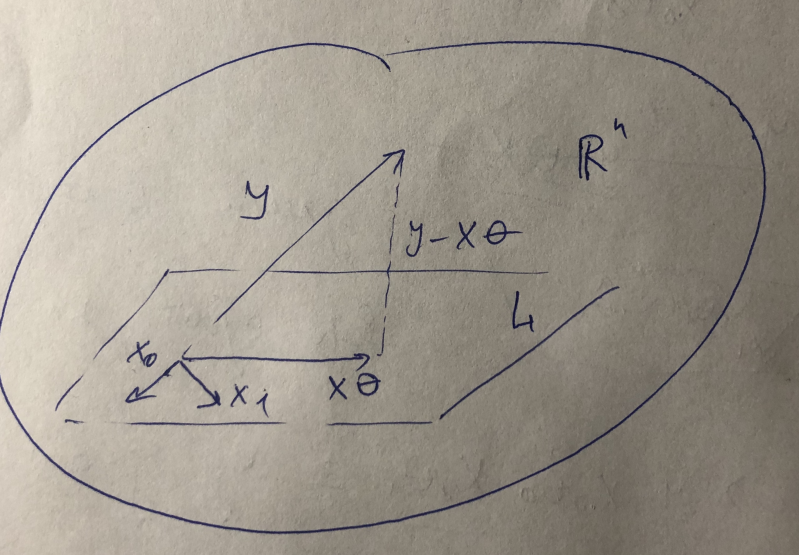

Пусть $X_0,X_1$ – столбцы регрессора $X$, они линейно независимы, а значит, порождают двумерное пространство $L = \R^2$. Кроме того,
$$X \Theta = X_0 \theta_0 + X_1 \theta_1 \in L$$
Из геометрических соображений ясно, что, согласно методу наименьших квадратов, мы минимизируем квадрат длины $Y - X \Theta$. Длина (квадрат длины) минимален, когда вектор $Y - X \Theta$ ортогонален $L$, то есть ортогонален каждому вектору $X_0$ и $X_1$:
$$(Y - X \Theta) \perp X_i, \; i=0,1.$$
Иными словами,
$$X^T(Y - X \Theta) = 0 \iff X^T Y - X^T X \Theta = 0.$$
Так как $\det(X^T X) \ne 0$, то $\Theta = \left(X^T X \right)^{-1} X^T Y$.

***
## <a id='toc1_3_'></a>[__Работа с признаками__](#toc0_)

В линейной модели предполагается конкретный вид зависимости - а именно, что каждый признак линейно влияет на целевую переменную, и что целевая переменная не зависит от каких-либо комбинаций признаков. Вряд ли это будет выполнено по умолчанию, поэтому обычно данные требуют специальной подготовки, чтобы линейные модели оказались адекватными задаче.

***
### <a id='toc1_3_1_'></a>[__One-hot encoding__](#toc0_)

Категориальные признаки нельзя использовать в линейных моделях, но есть достаточно распространённый способ их преобразования.

Категориальный признак $f_j(x)$, принимающий значения из множества $\{c_1,...,c_m\}$, заменяется на $m$ бинарных признаков $b_1(x),...,b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:

$$b_i(x) = [f_j(x) = c_i]$$

Отметим, что признаки $b_i(x),...,b_m(x)$ линейно зависимы: для любого объекта выполнено $b_i(x) +...+ b_m(x) = 1$. Чтобы избежать этого, можно выбрасывать один из бинарных признаков. Впрочем, такое решение имеет и недостатки - например, если на тестовой выборке появится новая категория, то ее как раз можно закодировать с помощью нулевых бинарных признаков (по принципу исключения). При удалении одного из них это потеряет смысл.

Линейная модель примет вид:

$$a(x) = w_1[f(x) = c_1] +...+ w_m[f(x) = c_m] + \{\text{свертка др. признаков}\}$$

Каждая категория, принадлежность к ней, задает некоторый базовый уровень значения целевой переменной (например, район $c_1$ задает базовую цену квартиры $w_1$), а остальные факторы корректируют его.

***
### <a id='toc1_3_2_'></a>[__Bag of words__](#toc0_)

Найдем все слова, которые есть в выборке текстов, и пронумеруем их: $\{c_1,...,c_m\}$. Будем кодировать текст $m$ признаками $b_1(x),...,b_m(x)$, где $b_j(x)$ равен количеству вхождений слова $c_j$ в текст. Линейная модель над такими признаками примет вид:

$$a(x) = w_1 b_1(x) +...+ w_m b_m(x) +...$$

Подход обоснован, поскольку разумно ожидать, что каждое вхождение слова $c_j$ вносит в текст окраску или меняет степень ее интенсивности и, таким образом, влияет на итоговое значение целевой переменной.

***
### <a id='toc1_3_3_'></a>[__Бинаризация числовых признаков__](#toc0_)

Рассмотрим случай, когда зависимость целевой переменной от признака нелинейна. Например, может оказаться, что самые дорогие квартиры расположены в $5$-$10$ минутах ходьбы от метро, а те, что ближе или дальше, стоят не так дорого. Чтобы сделать линейную модель подходящей, можно бинаризовать признак: выбрать некоторую сетку точек $\{t_1,...,t_m\}$ - равномерно между минимальным и максимальным значениями признака или, например, из эмпирических квантилей. Добавим сюда точки $t_0 = -\infty$ и $t_{m+1} = +\infty$. Новые признаки зададим как индикаторы попадания исходного признака в тот или иной интервал:

$$b_i(x) = [t_{i-1} < x_j \leqslant t_i], \; i = 1,...,m+1$$

Линейная модель над такими признаками примет вид:

$$a(x) = w_1 [t_0 < x_j \leqslant t_1] +...+ w_{m+1} [t_m < x_j \leqslant t_{m+1}] +...$$

Так мы найдем прогноз стоимости квартиры для каждого интервала расстояния до метро. Такой подход позволит учесть нелинейную зависимость между признаком и целевой переменной.

***
### <a id='toc1_3_4_'></a>[__Масштабирование__](#toc0_)

См. [__sklearn.preprocessing.StandardScaler__](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn-preprocessing-standardscaler), [__sklearn.preprocessing.MinMaxScaler__](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn-preprocessing-minmaxscaler).

***
## <a id='toc1_4_'></a>[__Измерение ошибки в задачах регрессии__](#toc0_)
***

### <a id='toc1_4_1_'></a>[__Функционалы ошибок RSE, RMSE, MSE__](#toc0_)

__Среднеквадратическое отклонение остатков RSE__ (_residual standard error_) для случая простейшей линейной регрессии:

$$\textbf{RSE} = \widehat{\sigma_0} = \sqrt{\frac{1}{n-2}\sum_{i=1}^n (y_i - \widehat{\theta_0} - \widehat{\theta_1} x_i)^2}$$

Обобщение на множественный случай в атрибутах обученной модели statsmodels OLS:
$$\textbf{RSE} = \sqrt{\textbf{mse\_resid}} = \sqrt{\frac{\textbf{ssr}}{\underbrace{\textbf{df\_resid}}_{\textbf{nobs} - \textbf{df\_model} - 1}}}; \quad \textbf{RMSE} = \sqrt{\frac{\textbf{ssr}}{\textbf{nobs}}}; \quad \textbf{MSE} = \frac{\textbf{ssr}}{\textbf{nobs}}$$

Разница между RSE и RMSE (_root mean squared error_) в усредняющем коэффициенте, между RMSE и MSE (_mean squared error_) - в извлечении квадратного корня для удобства интерпретации результата в тех же единицах измерения, что и целевая переменная.

__Среднеквадратичная ошибка MSE__ подходит для сравнения двух моделей или для
контроля качества во время обучения, но не позволяет сделать выводы о том, насколько хорошо данная модель решает задачу. Например, $\text{MSE} = 10$ является очень плохим показателем, если целевая переменная принимает значения от $0$ до $1$, и очень хорошим, если целевая переменная лежит в интервале $(10^4, 10^5)$. В таких ситуациях вместо среднеквадратичной ошибки полезно использовать __коэффициент детерминации__, _coefficient of determination_ (или коэффициент R2).

***
### <a id='toc1_4_2_'></a>[__Коэффициент детерминации R2__](#toc0_)
Для случая простейшей линейной регрессии:
$$\textbf{R}^2 = 1 - \frac{\sum_{i=1}^n (y_i - \widehat{\theta_0} - \widehat{\theta_1} x_i)^2}{\sum_{i=1}^n (y_i - \overline{y})^2}$$
Обобщение на множественный случай в атрибутах обученной модели statsmodels OLS:
$$\textbf{R}^2 = \textbf{rsquared} = 1 - \frac{\textbf{ssr}}{\textbf{centered\_tss}} = \frac{\textbf{centered\_tss} - \textbf{ssr}}{\textbf{centered\_tss}} = \frac{\textbf{ess}}{\textbf{centered\_tss}}$$

* R-squared is instead much more interesting because it tells you how much better
your regression model is in comparison to a single mean. It does so by providing you with a percentage of the unexplained variance of a mean as a predictor that actually your model was able to explain.
* Коэффициент детерминации измеряет долю дисперсии, объясненную моделью, в общей дисперсии целевой переменной. Фактически, данная мера качества - это нормированная среднеквадратичная ошибка:

$$\textbf{R}^2 = 1 - \frac{\frac{1}{\textbf{nobs}} \cdot \textbf{ssr}}{\frac{1}{\textbf{nobs}} \cdot \textbf{centered\_tss}} = 1 - \frac{\textbf{MSE}}{\textbf{D}(y)}$$

Если она близка к единице, то модель хорошо объясняет данные, если же она близка к нулю, то прогнозы сопоставимы по качеству с константным предсказанием.

***
### <a id='toc1_4_3_'></a>[__MAE__](#toc0_)

__Среднее абсолютное отклонение MAE__ (_mean absolute error_):
$$\textbf{MAE}(a, X) = \frac{1}{n} \sum_{i=1}^n |a(x_i) - y_i|,$$
где $a$ - прогноз модели.

Модуль отклонения не является дифференцируемым, но при этом менее чувствителен к выбросам. Квадрат отклонения, по сути, делает особый акцент на объектах с сильной ошибкой, и метод обучения будет в первую очередь стараться уменьшить отклонения на таких объектах. Если же эти объекты являются выбросами (то есть значение целевой переменной на них либо ошибочно, либо относится к другому распределению и должно быть проигнорировано), то такая расстановка акцентов
приведет к плохому качеству модели. Модуль отклонения в этом смысле гораздо
более терпим к сильным ошибкам. У квадратичной функции потерь штраф за ошибку растет нелинейно с ростом отклонения прогноза от ответа, а для абсолютной функции потерь равносильно снижение отклонения на одну и ту же величину для нормального объекта и для выброса. Заметим, что такая особенность MAE пропадет, если в выборке будет много выбросов. Скажем, если будет около половины объектов с аномальными значениями целевой переменной, то вполне может стать выгоднее оптимизировать отклонение именно на них.

Приведем еще одно объяснение того, почему модуль отклонения устойчив к выбросам, на простом примере. Допустим, все $n$ объектов выборки имеют одинаковые признаковые описания, но разные значения целевой переменной $y_1,...,y_n$. В этом
случае модель должна на всех этих объектах выдать один и тот же ответ, $a$. Если в качестве функционала ошибки выбран MSE, то решение задачи $\arg \min_a \frac{1}{n} \sum_{i=1}^n (a - y_i)^2$ достигается __на среднем__, в $a = \frac{1}{n} \sum_{i=1}^n y_i$. В то время как при выборе MAE решение $\arg \min_a \frac{1}{n} \sum_{i=1}^n |a - y_i|$ достигается __на медиане__, в $a = \text{median}\{y_i\}_{i=1}^n.$

Отметим проблему, связанную с абсолютной функцией потерь в контексте градиентных методов обучения. Производная MAE, $\frac{\partial}{\partial{a}} |a - y| = \text{sign}(a - y), \; a \ne y$, не зависит от близости прогноза
к правильному ответу, по ее значению невозможно оценить близость к оптимальному прогнозу. Из-за этого при оптимизации MAE можно легко перескочить
экстремум. Поэтому, как правило, использование этой функции потерь приводит к
более долгой и сложной процедуре обучения.

***
### <a id='toc1_4_4_'></a>[__MAPE, SMAPE__](#toc0_)

В задачах прогнозирования нередко измеряется относительная ошибка. Во-первых, это удобно для интерпретации — легко понять, что "ошибка 50%" соответствует отклонению в полтора раза от целевой переменной. Во-вторых, это позволяет работать с разными масштабами. Например, мы можем решать задачу прогнозирования спроса на товары в магазине, и какие-то товары могут продаваться штуками, а какие-то - тысячами. Чтобы при усреднении ошибок более популярные товары не оказывали большее влияние на результат, следует использовать функции потерь, не зависящие от масштаба, - относительные функции потерь.

__Средняя абсолютная процентная ошибка MAPE__ (_mean absolute percentage error_):

$$L(y, a) = \biggl|\frac{y - a}{y}\biggr|$$

Недостаток MAPE - асимметричность: скажем, если $y = 1$ и все прогнозы
неотрицательные, то максимальная ошибка при занижении прогноза $(a < y)$ равна
единице, а ошибка при завышении прогноза $(a > y)$ никак не ограничена сверху. Это исправляется в симметричной модификации - __SMAPE__ (_symmetric mean absolute percentage error_):

$$L_{\tiny \text{SMAPE}} = \frac{|y - a|}{(|y| + |a|)/2}$$
$$\lim_{a \to \infty} L_{\tiny \text{SMAPE}} = \lim_{a \to -\infty} L_{\tiny \text{SMAPE}} = 2$$

***
### <a id='toc1_4_5_'></a>[__Adjusted R2, AIC__](#toc0_)

Including additional variables always reduces RMSE and increases R2 for the training data. Hence, these are not appropriate to help guide the model choice. One approach to including model complexity is to use the __adjusted R2__:

$$\textbf{R}^2_{adj} = 1 - \frac{(1 - \textbf{R}^2)(n - 1)}{n - p - 1}$$

__Akaike's Information Criteria (AIC)__ penalizes adding terms to a model:
$$\textbf{AIC} = 2p + n \log(\textbf{ssr} / n)$$

($n$ for $\text{nobs}$, $p$ for $\text{df\_model}$ в обоих выражениях выше)

***
## <a id='toc1_5_'></a>[__Обучение линейной регрессии__](#toc0_)
***

### <a id='toc1_5_1_'></a>[__Ключевые понятия__](#toc0_)

Модель называется __переобученной__ (_overfitted_), если ее качество на новых данных существенно хуже качества на обучающей выборке. Переобученность проявляется в чрезмерно плотной подгонке модели под выборку, в чрезмерной зависимости модели от выборки, что приводит к низкой __обобщающей способности__ модели - к низкому качеству предсказаний на новых данных. Характерный симптом переобученности - большие коэффициенты при признаках, что, например, заметно при использовании полиномов высоких степеней. Проблема переобученности можно решать многими способами - например, использовать более узкий класс моделей или штрафовать за излишнюю сложность модели. На последнем основан подход __регуляризации__ - использование нормы вектора коэффициентов как штрафующего фактора, добавки, отягощающей функционал ошибки.

Наглядный пример переобучения модели. Сгенерируем синтетические данные. Рассмотрим зависимость $y = f(x) = \cos \frac{3\pi}{2} x$, где $y$ - целевая переменная, $x$ - объект, число от $0$ до $1$. Смоделируем ситуацию ограниченного количества пар объект-таргет $30$-ю случайными точками $x_i$ из отрезка $[0,1]$. Целевая переменная может быть зашумленной - например, погрешностью измерений. Смоделируем это, добавив к значению функции нормальный шум: $\tilde{y}_i = f(x_i) + \text{N}_{0,\,0.01}$.

Обучим 3 линейных модели с наборами признаков соответственно $\{x\}$, $\{x, x^2, x^3, x^4\}$, $\{x, \dots, x^{20}\}$.

In [1365]:
def polynomialFeatures(arr, deg):
    """https://bit.ly/3JAGEib"""
    poly = PolynomialFeatures(deg, include_bias=False)
    return poly.fit_transform(arr.reshape(-1,1))

In [1366]:
f = lambda x: np.cos(1.5 * np.pi * x)
params = {'size': 30, 'random_state': 36}
noise = norm.rvs(scale=0.1, **params)
xdata = uniform.rvs(scale=1, **params)
ydata = f(xdata) + noise
x = np.linspace(0, 1, 101)
degrees = 1, 4, 20

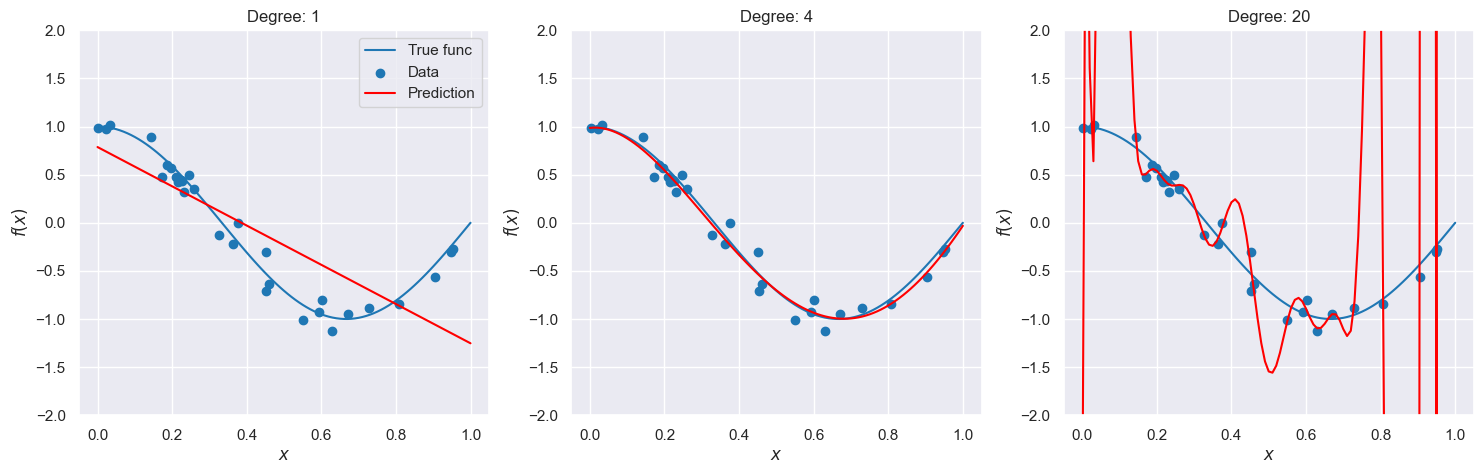

In [1367]:
fig, axs = plt.subplots(figsize=(18,5), ncols=3)

for i, deg in enumerate(degrees):
    X, Xdata = (polynomialFeatures(arr, deg) for arr in (x, xdata))
    reg = LinearRegression().fit(Xdata, ydata)
    ypred = reg.predict(X)
    axs[i].plot(x, f(x), label='True func')
    axs[i].scatter(xdata, ydata, label='Data')
    axs[i].plot(x, ypred, c='red', label='Prediction')
    axs[i].set_title(f'Degree: {deg}')
    axs[i].set_xlabel('$x$')
    axs[i].set_ylabel('$f(x)$')
    axs[i].set_ylim(-2,2)
    
axs[0].legend()
plt.show()

Обнаружить переобученность по обучающей выборке нельзя. Поэтому применяется подход __отложенной выборки__ - разделения размеченных данных на обучающую выборку и контрольную. Использование отложенной выборки вносит эффект неопределенности: результат существенно зависит от конкретного разбиения данных на обучение и контроль. Мы не знаем, какое качество получилось бы, если бы объекты из данного контроля оказались в обучении. Решить эту проблему можно с помощью __кросс-валидации__. Размеченные данные разбиваются на $k$ блоков $X_1,...,X_k$ примерно одинакового размера. Затем обучаются $k$ моделей $a_1(x),...,a_k(x)$, причем $i$-я модель обучается на объектах из всех блоков, кроме блок $a_i$. После этого качество каждой модели оценивается по тому блоку, который не участвовал в ее обучении, и результаты усредняются:

$$\textbf{CV} = \frac{1}{k} \sum_{i=1}^k Q(a_i(x), X_i)$$

Если после кросс-валидации модели $a_i(x)$ обобщают удовлетворительно, получить финальную модель можно:
1. Обучением модели на всех доступных данных.
2. __Композицией__ моделей - например, усреднением прогнозов моделей, если решается задача регрессии.

***
### <a id='toc1_5_2_'></a>[__Регуляризация. Ridge. LASSO. Elastic Net__](#toc0_)

Точное решение задачи линейной регрессии с MSE,

$$w = \left(X^T X\right)^{-1} X^T y,$$

не всегда применимо. Возможные ограничения:
* Обращение матрицы операция с кубической сложностью от количества признаков.
* Матрица $X^T X$ может быть вырожденной или плохо обусловленной. В этом случае обращение либо невозможно, либо может привести к неустойчивым результатам. Проблема решается с помощью регуляризации.

Если матрица $X^T X$ не является обратимой, то с оптимизацией среднеквадратичной ошибки могут возникнуть трудности. В ряде случаев (признаков больше чем объектов, коррелирующие признаки) оптимизационная задача $\arg \min_w Q(w)$ может иметь бесконечное число решений, большинство которых являются переобученными и плохо работают на тестовых данных: если в выборке есть линейно зависимые признаки, то метод оптимизации может найти решение со сколь угодно большими весами. Такие решения не очень хороши, поскольку классификатор будет чувствителен к крайне малым изменениям в признаках объекта, а значит, переобучен. Переобучение нередко приводит к большим значениям коэффициентов. Чтобы решить эту проблему, добавим к функционалу __регуляризатор__, который штрафует за слишком большую норму вектора весов:

$$Q_{\alpha}(w) = Q(w) + \alpha R(w)$$

Наиболее распространенными являются $L_2$ и $L_1$-регуляризаторы:

$$R(w) = ||w||_2 = \sum_{i=1}^p w_i^2 \\
R(w) = ||w||_1 = \sum_{i=1}^p |w_i|$$

Коэффициент $\alpha$ называется __параметром регуляризации__ и контролирует баланс между подгонкой под обучающую выборку и штрафом за излишнюю сложность. Разумеется, значение данного параметра следует подбирать под каждую задачу. Отметим, что свободный коэффициент $w_0$ нет смысла регуляризовывать. Это означало бы априорное представление о близости целевой переменной к нулю и отсутствии необходимости учета ее смещения. Если в выборке есть константный признак, следует исключить слагаемое, соответствующее константному признаку, из регуляризатора.

Оптимальный вектор весов при использовании $L_2$-регуляризации вместе со среднеквадратичной ошибкой:

$$\Large w = \left(X^T X + \alpha I\right)^{-1} X^T y$$

Благодаря добавлению диагональной матрицы к $X^T X$ результирующая матрица оказывается положительно определенной, и поэтому ее можно обратить. Таким образом, при использовании $L_2$-регуляризации решение всегда будет единственным.

Regularization works by enriching the learning process using a penalization for too complex models to shrink (or reduce to zero) coefficients relative to variables that are irrelevant for your prediction term or are redundant, as they are highly correlated with others present in the model.

__Ridge regression__ is an $L_2$ penalized model where we add the squared sum of the weights to the MSE loss function:

$$L(w)_{\tiny \text{Ridge}} = \frac{1}{n} \sum_{i=1}^n \left(\langle w,x_i\rangle - y_i\right)^2 + \alpha ||w||^2_2$$

An alternative approach that can lead to sparse models is __LASSO__ (_least absolute shrinkage and selection operator_). Depending on the regularization
strength, certain weights can become zero, which also makes LASSO useful as a supervised feature selection technique:

$$L(w)_{\tiny \text{LASSO}} = \frac{1}{n} \sum_{i=1}^n \left(\langle w,x_i\rangle - y_i\right)^2 + \alpha ||w||_1$$

However, a limitation of LASSO is that it selects at most $n$ features if $p > n$. A compromise between ridge regression and LASSO is __elastic net__, which has an $L_1$ penalty to generate sparsity and an $L_2$ penalty such that it can be used for selecting more than $n$ features if $p > n$:

$$L(w)_{\tiny \text{Elastic Net}} = \frac{1}{n} \sum_{i=1}^n \left(\langle w,x_i\rangle - y_i\right)^2 + \alpha_2 ||w||^2_2 + \alpha_1 ||w||_1$$

***
### <a id='toc1_5_3_'></a>[__Гиперпараметры__](#toc0_)

В машинном обучении принято разделять подлежащие настройке величины на параметры и гиперпараметры. __Параметрами__ называют величины, которые настраиваются по обучающей выборке - например, веса в линейной регрессии. К __гиперпараметрам__ относят величины, которые контролируют сам процесс обучения и не могут быть подобраны по обучающей выборке. Хорошим примером гиперпараметра является коэффициент регуляризации $\alpha$. Введение регуляризации мешает модели подгоняться под обучающие данные, и с точки зрения среднеквадратичной ошибки выгодно всегда брать $\alpha = 0$. Разумеется, такой выбор не будет оптимальным с точки зрения качества на новых данных, и поэтому коэффициент регуляризации (как и другие гиперпараметры) следует настраивать по отложенной выборке или с помощью кросс-валидации. 

При подборе гиперпараметров по кросс-валидации возникает проблема: мы используем отложенные данные, чтобы выбрать лучший набор гиперпараметров. По сути, отложенная выборка тоже становится обучающей, и показатели качества на ней перестают характеризовать обобщающую способность модели. В таких случаях выборку, на которой настраиваются гиперпараметры, называют __валидационной__, и при этом выделяют третий, тестовый набор данных, на которых оценивается качество итоговой модели.

***
## <a id='toc1_6_'></a>[__Полиномиальная регрессия__](#toc0_)

Модель линейной регрессии без существенных усложнений может быть расширена до модели полиномиальной регрессии:

$$y = \theta_0 + \theta_1 X + ... + \theta_p X^p$$

Важно отметить, что коэффициенты модели могут быть найдены с помощью МНК, описанного выше, ведь перед нами не что иное, как многомерная линейная регрессия, только вместо предикторов взяты степени $X$:

$$X_1 = X,...,X_p = X^p$$

См. [__sklearn.preprocessing.PolynomialFeatures__](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures), [__numpy.polyfit__](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html#numpy-polyfit).

***
## <a id='toc1_7_'></a>[__Краткий обзор функционала класса statsmodels OLS__](#toc0_)

[__statsmodels: Linear Regression__](https://www.statsmodels.org/stable/regression.html#regression--page-root) | [__Ordinary Least Squares__](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html#examples-notebooks-generated-ols--page-root) | [__OLSResults__](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#generated-statsmodels-regression-linear-model-olsresults--page-root)

Обзор главных методов, атрибутов, связей между атрибутами. В большинстве случаев дополнительные комментарии к фрагментам кода не требуются.

In [1368]:
dset = pd.read_csv('candy-data.csv').set_index('competitorname')
dset.head()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent,Y
competitorname,,,,,,,,,,,,,
100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725,1
3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936,1
One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086,0
One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505,0
Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465,1


In [1369]:
testers = ['Charleston Chew', 'Dum Dums']
df = dset.drop(index=testers)

In [1370]:
predictors = [
    'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
    'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus',
    'sugarpercent', 'pricepercent'
]

In [1371]:
# в конструкторе sm.OLS зависимая переменная на первом месте
model = sm.OLS(df.winpercent, sm.add_constant(df[predictors]))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             winpercent   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     8.949
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           6.28e-09
Time:                        20:59:39   Log-Likelihood:                -246.21
No. Observations:                  68   AIC:                             516.4
Df Residuals:                      56   BIC:                             543.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               37.0424      4.887      7.579      0.000      27.252      46.833
chocolate           27.9655      4.615      6.060      0.000      18.721      37.210
fruity              11.2469      4.190      2.684      0.010       2.854      19.640
caramel             -5.5359      4.291     -1.290      0.202     -14.131       3.060
peanutyalmondy       6.0961      3.552      1.716      0.092      -1.019      13.211
nougat               9.3505      6.228      1.501      0.139      -3.127      21.828
crispedricewafer    10.5860      5.999      1.764      0.083      -1.432      22.604
hard                -7.2885      3.713     -1.963      0.055     -14.727       0.150
bar                 -6.0876      5.616     -1.084      0.283     -17.338       5.163
pluribus            -4.8736      3.364     -1.449      0.153     -11.613       1.866
sugarpercent        12.9148      4.648      2.779      0.007       3.604      22.225
pricepercent       -11.1743      5.826     -1.918      0.060     -22.845       0.497
==============================================================================
Omnibus:                        0.961   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.426
Skew:                          -0.133   Prob(JB):                        0.808
Kurtosis:                       3.283   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1372]:
res.predict(sm.add_constant(dset.loc[testers, predictors]))

competitorname
Charleston Chew    70.361328
Dum Dums           50.074586
dtype: float64

In [1373]:
# The estimated parameters
res.params

const               37.042418
chocolate           27.965510
fruity              11.246945
caramel             -5.535882
peanutyalmondy       6.096051
nougat               9.350549
crispedricewafer    10.585964
hard                -7.288465
bar                 -6.087609
pluribus            -4.873574
sugarpercent        12.914772
pricepercent       -11.174292
dtype: float64

Предсказание эквивалентно через скалярное произведение значений признаков и соответствующих коэффициентов (весов) с добавлением свободного члена:

In [1374]:
dset.loc[testers, predictors]

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent
competitorname,,,,,,,,,,,
Charleston Chew,1,0,0,0,1,0,0,1,0,0.604,0.511
Dum Dums,0,1,0,0,0,0,1,0,0,0.732,0.034


In [1375]:
dset.loc[testers, predictors] @ res.params[1:] + res.params.const

competitorname
Charleston Chew    70.361328
Dum Dums           50.074586
dtype: float64

Предсказание на произвольном объекте:

In [1376]:
some_obj = np.array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0.885, 0.649])
some_obj @ res.params[1:] + res.params.const

45.73985197101008

In [1377]:
res.predict(np.insert(some_obj, 0, 1)).item()

45.73985197101009

In [1378]:
# The residuals of the model
res.resid

competitorname
100 Grand                 3.157602
3 Musketeers             -2.758392
One dime                 -3.627177
One quarter              14.642087
Air Heads                -1.938619
                           ...    
Snickers Crisper        -11.063258
Sour Patch Kids          16.853307
Sour Patch Tricksters     9.815256
Starburst                24.130052
Strawberry bon bons      -8.248730
Length: 68, dtype: float64

In [1379]:
# The standard errors of the parameter estimates
res.bse

const               4.887238
chocolate           4.614797
fruity              4.189794
caramel             4.290827
peanutyalmondy      3.551890
nougat              6.228481
crispedricewafer    5.999432
hard                3.713185
bar                 5.616078
pluribus            3.364097
sugarpercent        4.647718
pricepercent        5.826038
dtype: float64

In [1380]:
np.allclose(res.params / res.bse, res.tvalues)

True

In [1381]:
res.pvalues

const               3.816298e-10
chocolate           1.214091e-07
fruity              9.539808e-03
caramel             2.022949e-01
peanutyalmondy      9.163775e-02
nougat              1.389070e-01
crispedricewafer    8.310218e-02
hard                5.463696e-02
bar                 2.830270e-01
pluribus            1.529974e-01
sugarpercent        7.414017e-03
pricepercent        6.021666e-02
dtype: float64

In [1382]:
res.conf_int(alpha=.05)  # configurable alpha level

,0,1
const,27.252105,46.832732
chocolate,18.720960,37.210060
fruity,2.853779,19.640111
caramel,-14.131441,3.059676
peanutyalmondy,-1.019240,13.211341
nougat,-3.126597,21.827696
crispedricewafer,-1.432341,22.604270
hard,-14.726869,0.149939
bar,-17.337964,5.162746
pluribus,-11.612670,1.865522


In [1383]:
# The predicted values for the original (unwhitened) design
res.fittedvalues

competitorname
100 Grand                63.814123
3 Musketeers             70.361328
One dime                 35.888263
One quarter              31.474418
Air Heads                54.280084
                           ...    
Snickers Crisper         70.592509
Sour Patch Kids          43.010691
Sour Patch Tricksters    43.010691
Starburst                42.907576
Strawberry bon bons      42.827721
Length: 68, dtype: float64

In [1384]:
res.predict(sm.add_constant(df[predictors]))

competitorname
100 Grand                63.814123
3 Musketeers             70.361328
One dime                 35.888263
One quarter              31.474418
Air Heads                54.280084
                           ...    
Snickers Crisper         70.592509
Sour Patch Kids          43.010691
Sour Patch Tricksters    43.010691
Starburst                42.907576
Strawberry bon bons      42.827721
Length: 68, dtype: float64

In [1385]:
# The total (weighted) sum of squares centered about the mean
res.centered_tss

15327.3006883437

In [1386]:
np.square(df.winpercent - df.winpercent.mean()).sum()

15327.3006883437

In [1387]:
# Sum of squared (whitened) residuals
res.ssr

5557.88900450283

In [1388]:
np.square(df.winpercent - res.fittedvalues).sum()

5557.889004502829

In [1389]:
res.mse_resid * res.df_resid == res.ssr

True

In [1390]:
res.scale == res.mse_resid

True

In [1391]:
rse = np.sqrt(res.mse_resid)
rse

9.962329945226195

In [1392]:
# The explained sum of squares
res.ess

9769.41168384087

In [1393]:
res.centered_tss - res.ssr == res.ess

True

In [1394]:
res.ess / res.centered_tss

0.637386313642978

In [1395]:
res.ess / res.centered_tss == res.rsquared

True

In [1396]:
1 - res.ssr / res.centered_tss == res.rsquared

True

In [1397]:
"""The model degrees of freedom. 
This is equal to p - 1, where p is the number of regressors. 
Note that the intercept is not counted as using a degree of freedom here."""

res.df_model

11.0

In [1398]:
res.mse_model * res.df_model == res.ess

True

In [1399]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.566   
Dependent Variable:  winpercent       AIC:                516.4113
Date:                2023-03-14 20:59 BIC:                543.0454
No. Observations:    68               Log-Likelihood:     -246.21 
Df Model:            11               F-statistic:        8.949   
Df Residuals:        56               Prob (F-statistic): 6.28e-09
R-squared:           0.637            Scale:              99.248  
------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
const             37.0424   4.8872  7.5794 0.0000  27.2521 46.8327
chocolate         27.9655   4.6148  6.0600 0.0000  18.7210 37.2101
fruity            11.2469   4.1898  2.6844 0.0095   2.8538 19.6401
caramel           -5.5359   4.2908 -1.2902 0.2023 -14.1314  3.0597
peanutyalmondy     6.0961   3.5519  1.7163 0.0916  -1.0192 13.2113
nougat             9.3505   6.2285  1.5013 0.1389  -3.1266 21.8277
crispedricewafer  10.5860   5.9994  1.7645 0.0831  -1.4323 22.6043
hard              -7.2885   3.7132 -1.9629 0.0546 -14.7269  0.1499
bar               -6.0876   5.6161 -1.0840 0.2830 -17.3380  5.1627
pluribus          -4.8736   3.3641 -1.4487 0.1530 -11.6127  1.8655
sugarpercent      12.9148   4.6477  2.7787 0.0074   3.6043 22.2253
pricepercent     -11.1743   5.8260 -1.9180 0.0602 -22.8452  0.4967
------------------------------------------------------------------
Omnibus:              0.961         Durbin-Watson:           1.919
Prob(Omnibus):        0.619         Jarque-Bera (JB):        0.426
Skew:                 -0.133        Prob(JB):                0.808
Kurtosis:             3.283         Condition No.:           11   
==================================================================

"""

In [1400]:
statistic = res.tvalues.caramel
statistic

-1.29016684963188

С учетом того, что тест двусторонний и статистика отрицательная:

In [1401]:
np.isclose(res.pvalues.caramel, 2 * t.cdf(statistic, df=res.df_resid))

True

***
## <a id='toc1_8_'></a>[__Краткий обзор функционала классов scikit-learn для линейной регрессии__](#toc0_)

In [1402]:
reg = LinearRegression().fit(df[predictors], df.winpercent)

In [1403]:
# веса модели
reg.coef_

array([ 27.9655099 ,  11.24694514,  -5.53588243,   6.09605053,
         9.35054942,  10.58596423,  -7.28846514,  -6.08760902,
        -4.8735739 ,  12.91477216, -11.174292  ])

In [1404]:
np.allclose(reg.coef_, res.params[1:])

True

In [1405]:
# свободный член
reg.intercept_

37.042418399182075

In [1406]:
np.isclose(reg.intercept_, res.params.const)

True

In [1407]:
reg.predict(dset.loc[testers, predictors])

array([70.3613277 , 50.07458554])

In [1408]:
reg.predict([some_obj]).item()

45.73985197101008

In [1409]:
reg.score(df[predictors], df.winpercent)

0.637386313642978

In [1410]:
reg.score(df[predictors], df.winpercent) == res.rsquared

True

Классы линейной регрессии:

* [__LinearRegression__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html): "классическая" линейная регрессия с оптимизацией MSE. Веса находятся точным решением $w = (X^T X)^{-1} X^T y$;
* [__Ridge__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html): линейная регрессия с оптимизацией MSE и $L_2$-регуляризацией;
* [__Lasso__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html): линейная регрессия с оптимизацией MSE и $L_1$-регуляризацией.

***
## <a id='toc1_9_'></a>[__House Prices - Advanced Regression Techniques__](#toc0_)

[__dataset overview__](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

***
### <a id='toc1_9_1_'></a>[__Часть 1. Загрузка и обзор данных__](#toc0_)

In [1411]:
df = pd.read_csv('HousePrices.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1412]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

[__Overfitting due to a unique identifier among features__](https://stats.stackexchange.com/questions/224565/overfitting-due-to-a-unique-identifier-among-features)

In [1413]:
df = df.drop(columns='Id')

y = df.SalePrice
X = df.drop(columns='SalePrice')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10
)

XSubsets = X_train, X_test
ySubsets = y_train, y_test

Распределение значений целевой переменной показывает наличие объектов с нехарактерно высокой стоимостью. Это может помешать, если функция потерь чувствительна к выбросам. Ниже буду рассмотрены способы решения этой проблемы.

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

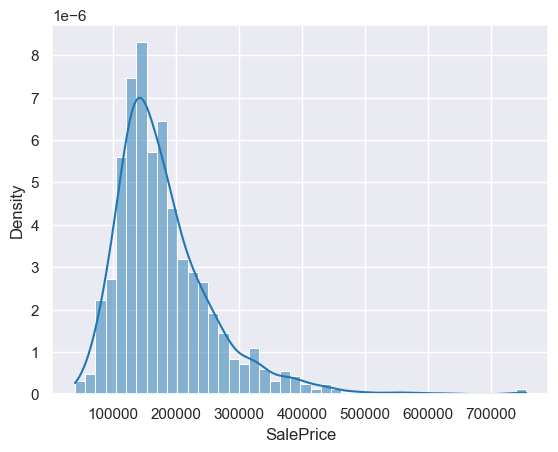

In [1414]:
sns.histplot(y_train, stat='density', kde=True)

При решении задачи линейной регрессии важно выделить признаки, имеющие наиболее сильно выраженную линейную связь с целевой переменной. Нечисловые признаки пока останутся без внимания.

In [1415]:
num_data = X_train.select_dtypes(exclude='object')
num_data_mean = num_data.mean()
nums = num_data.columns

for subset in XSubsets:
    subset.fillna(num_data_mean, inplace=True)

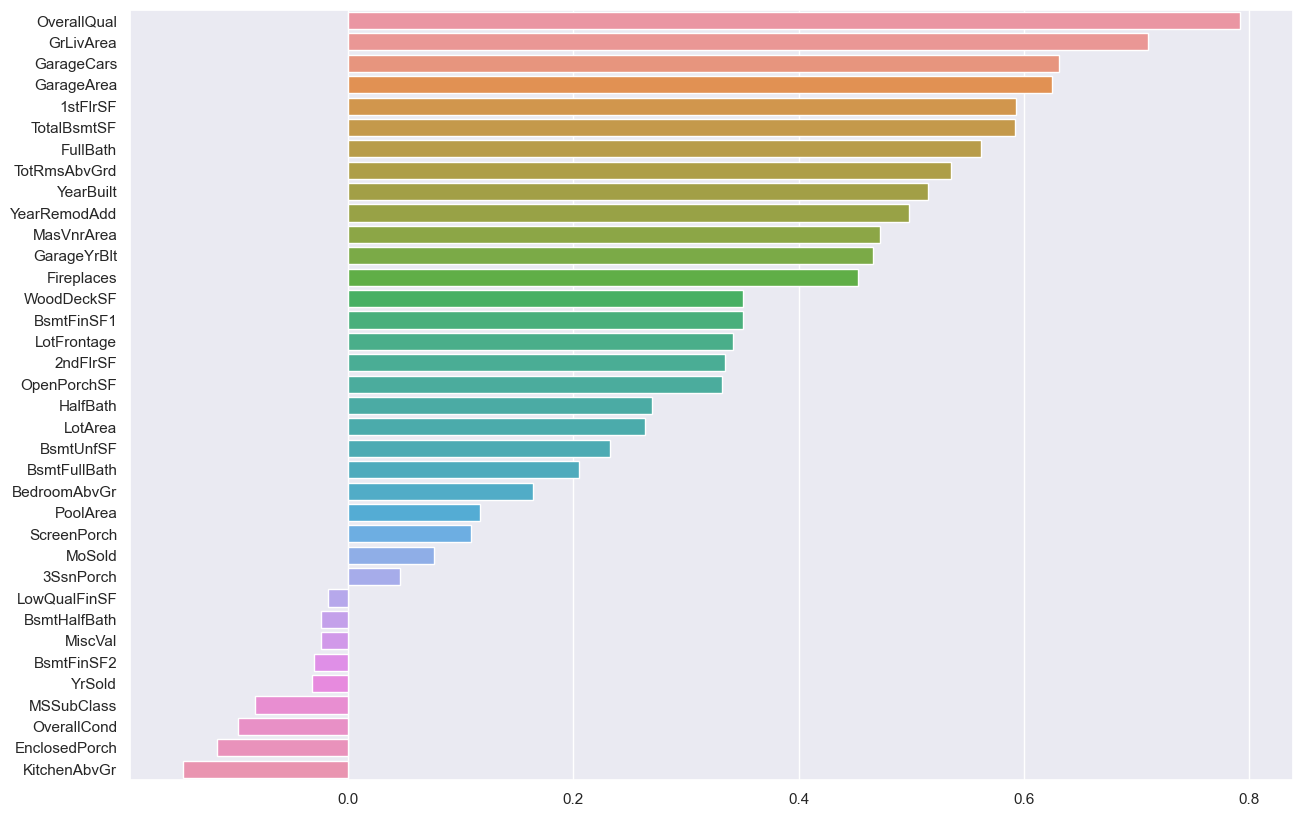

In [1416]:
corr = X_train[nums].corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=corr.index, x=corr)
plot.figure.set_size_inches(15,10)

Построим диаграммы рассеяния для трех выбранных признаков, сильно коррелирующих с целевой переменной.

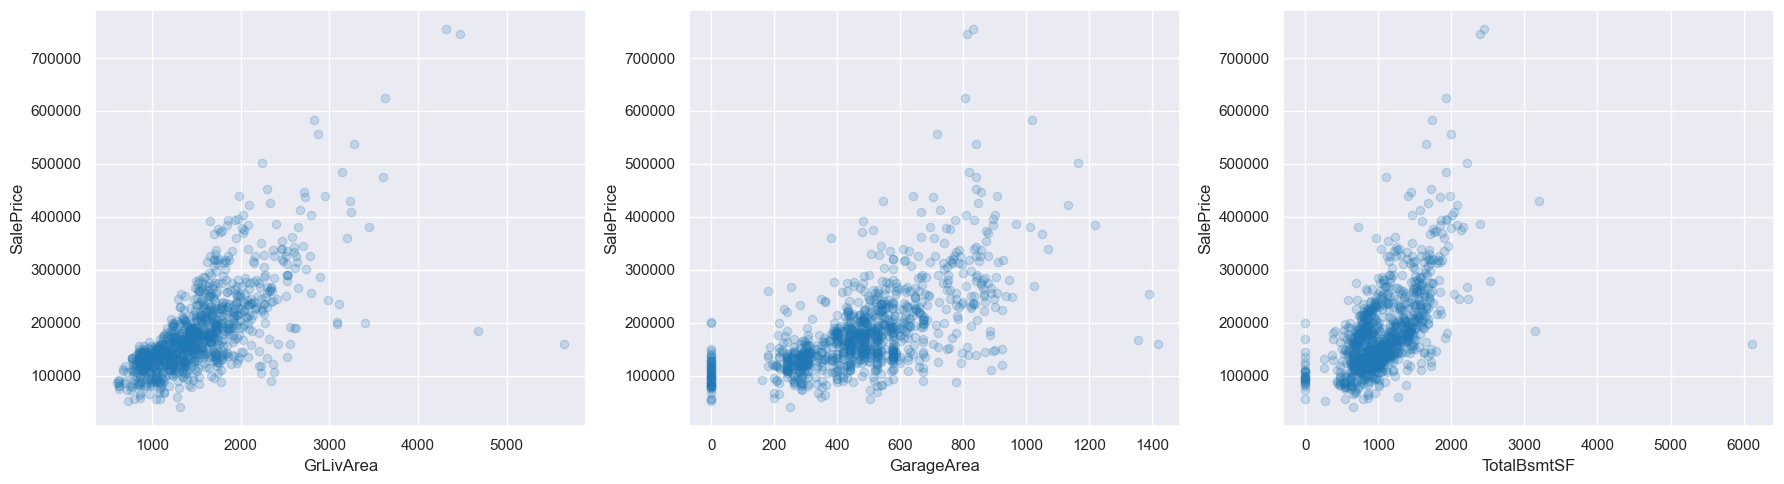

In [1417]:
feats = 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
fig, axs = plt.subplots(figsize=(18,5), ncols=3)

for i, feat in enumerate(feats):
    axs[i].scatter(X_train[feat], y_train, alpha=0.2)
    axs[i].set_xlabel(feat)
    axs[i].set_ylabel('SalePrice')
    
plt.tight_layout()  # adjust the padding between and around subplots

***
### <a id='toc1_9_2_'></a>[__Часть 2. Первая модель__](#toc0_)

In [1418]:
def trainTestResult(name: str) -> namedtuple:
    """Train and test results namedtuple factory. """
    return namedtuple(f'{name}Result', ['train', 'test'])

In [1419]:
RMSE = trainTestResult('RMSE')

In [1420]:
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred, squared=False), 3)

In [1421]:
def rmseResult(ySubsets, fitted):
    return RMSE(*(rmse(*pair) for pair in zip(ySubsets, fitted)))

In [1422]:
ridge = Ridge()
ridge.fit(X_train[nums], y_train)
fitted = (ridge.predict(subset[nums]) for subset in XSubsets)
rmseResult(ySubsets, fitted)

RMSEResult(train=35631.313, test=32085.768)

Оценим качество модели с помощью кросс-валидации.

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

In [1423]:
cv_scores = lambda scoring: cross_val_score(
    ridge, X_train[nums], y_train,
    cv=10, scoring=scoring
)

In [1424]:
cvScores = cv_scores('neg_root_mean_squared_error')
cvScores

array([-38825.31717909, -45278.92300502, -31405.33796779, -33890.10481383,
       -73848.30606948, -24142.79151142, -45523.70661782, -52861.29079228,
       -26094.33764832, -29693.50050299])

In [1425]:
-cvScores.mean()

40156.36161080559

__`cvScores`__ отрицательные, поскольку скоринговая функция подлежит максимизации. См. [__sklearn predefined scorers__](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values). Скорер своими руками:

In [1426]:
def rmseHandmade(y_true, y_pred):
    error = np.square(y_true - y_pred)
    return np.sqrt(np.mean(error))


rmseScorer = make_scorer(score_func=rmseHandmade, greater_is_better=False)
np.allclose(cv_scores(rmseScorer), cvScores)

True

Для того, чтобы иметь некоторую точку отсчета, ориентир, посчитаем оптимальное значение функции потерь при константном предсказании.

__Refresh__. Если в качестве функционала ошибки выбран MSE, то решение задачи $\arg \min_a \frac{1}{n} \sum_{i=1}^n (a - y_i)^2$ достигается __на среднем__, в $a = \frac{1}{n} \sum_{i=1}^n y_i$.

In [1427]:
best_constant = y_train.mean()

rmserr = (rmse(subset, best_constant * np.ones(subset.shape))
          for subset in ySubsets)

RMSE(*rmserr)

RMSEResult(train=80588.619, test=76636.519)

In [1428]:
def plotWeights(*, features, weights, scales):
    indices = np.flip(np.argsort(weights))
    args = weights, scales, features
    args = [arg[indices] for arg in args]
    axs = plt.subplots(figsize=(14,10), ncols=2)[1]
    for n, label in enumerate(['Weight', 'Scale']):
        sns.barplot(x=args[n], y=args[2], ax=axs[n])
        axs[n].set_xlabel(label)
    plt.tight_layout()

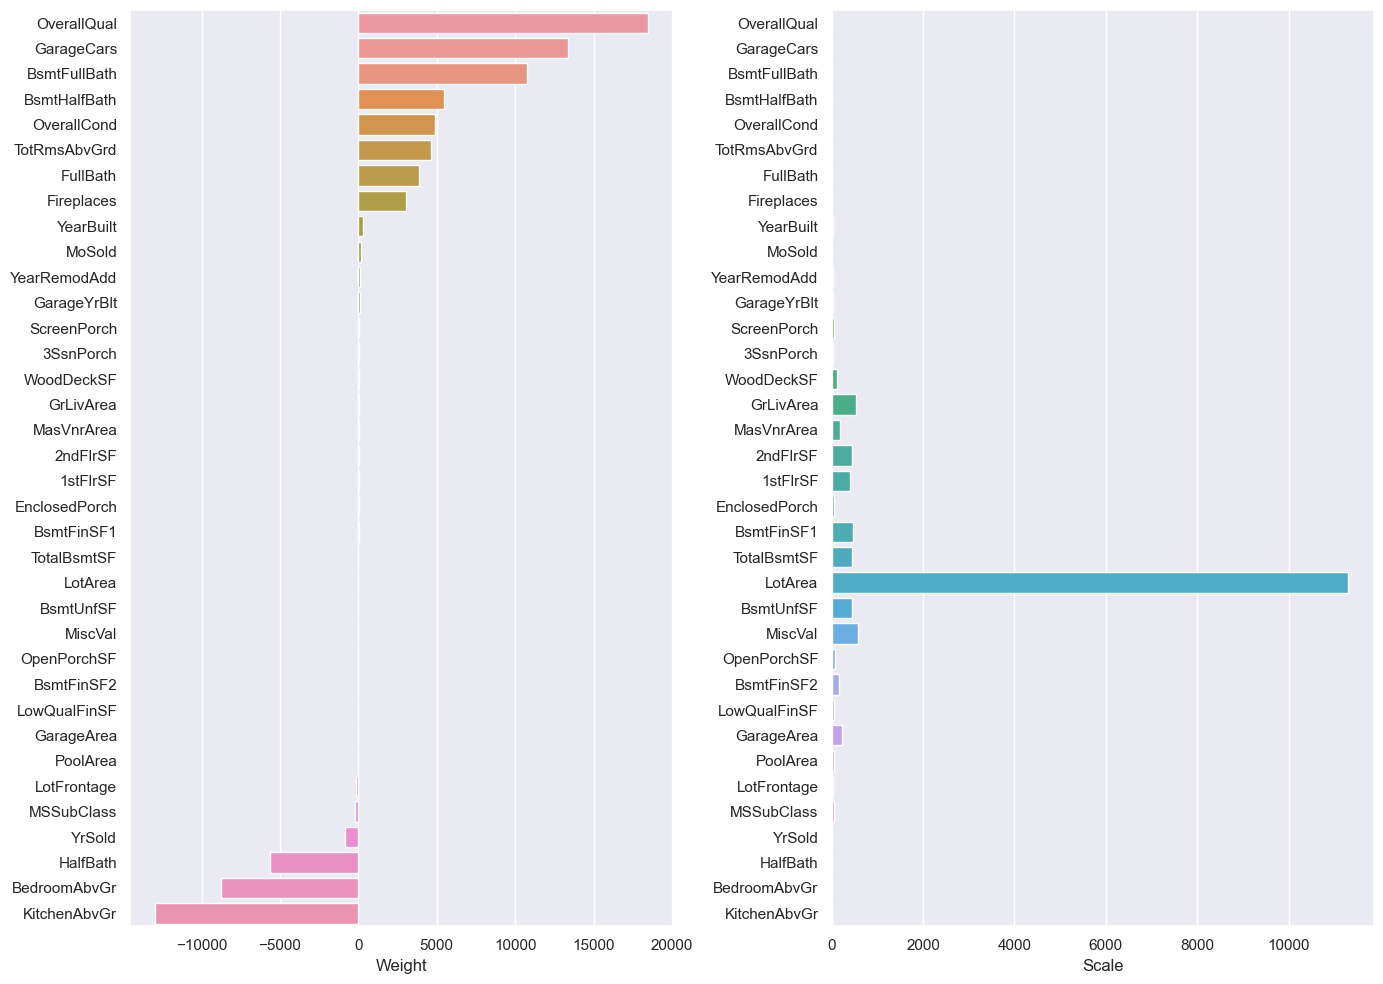

In [1429]:
plotWeights(features=nums, weights=ridge.coef_, scales=X_train[nums].std())

Масштабируем признаки перед обучением модели. Это сделает регуляризацию более честной: все признаки будут регуляризоваться в равной степени.

In [1430]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[nums])
X_test_scaled = scaler.transform(X_test[nums])
XSubsetsScaled = X_train_scaled, X_test_scaled

In [1431]:
ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
fitted = (ridge.predict(subset) for subset in XSubsetsScaled)
rmseResult(ySubsets, fitted)

RMSEResult(train=35631.216, test=32085.315)

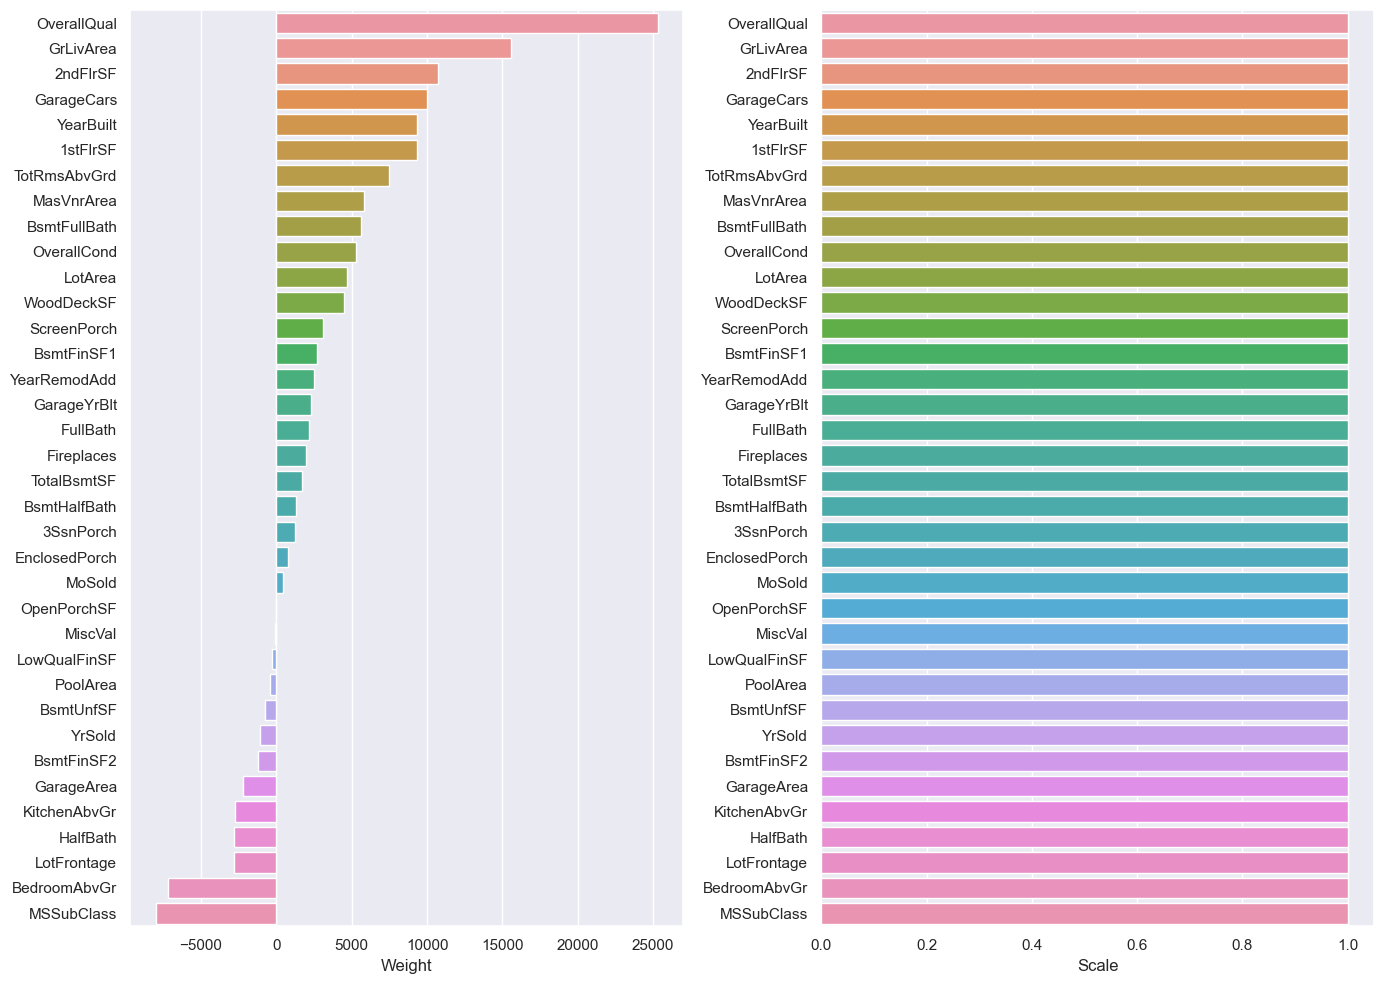

In [1432]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=nums)
plotWeights(features=nums, weights=ridge.coef_, scales=scales)

In [1433]:
alphas = np.logspace(-2, 3, 20)

searcher = GridSearchCV(
    Ridge(), param_grid={'alpha': alphas}, 
    scoring='neg_root_mean_squared_error', cv=10
)

searcher.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-02, 1.83298071e-02, 3.35981829e-02, 6.15848211e-02,
       1.12883789e-01, 2.06913808e-01, 3.79269019e-01, 6.95192796e-01,
       1.27427499e+00, 2.33572147e+00, 4.28133240e+00, 7.84759970e+00,
       1.43844989e+01, 2.63665090e+01, 4.83293024e+01, 8.85866790e+01,
       1.62377674e+02, 2.97635144e+02, 5.45559478e+02, 1.00000000e+03])},
             scoring='neg_root_mean_squared_error')

In [1434]:
def bestAlpha(searcher: GridSearchCV) -> float:
    param_name, alphas = searcher.param_grid.popitem()
    param_best = searcher.best_params_[param_name]
    mean_score = -searcher.cv_results_['mean_test_score']
    plt.figure(figsize=(5,4))
    plt.plot(alphas, mean_score, lw=1)
    plt.vlines(param_best, *describe(mean_score).minmax,
               color='red', ls='--', lw=0.5,
               label=f'$\\alpha = {param_best:.2f}$')
    plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('CV score')
    plt.legend()
    plt.show()
    return param_best

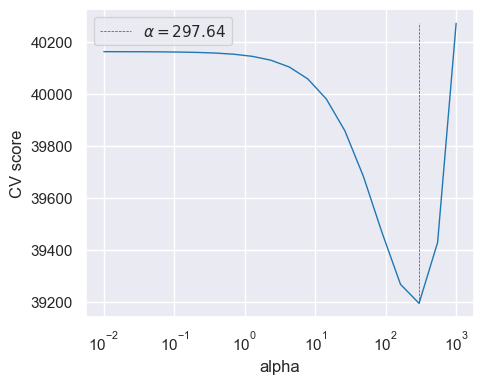

In [1435]:
best_alpha = bestAlpha(searcher)

In [1436]:
steps = {'scaling': StandardScaler(), 'regression': Ridge(best_alpha)}
simple_pipeline = Pipeline(steps.items())

model = simple_pipeline.fit(X_train[nums], y_train)
rmse(y_test, model.predict(X_test[nums]))

31703.359

***
### <a id='toc1_9_3_'></a>[__Часть 3. Обработка категориальных признаков__](#toc0_)

In [1437]:
cats = X_train.select_dtypes(include='object').columns

for subset in XSubsets:
    subset[cats] = subset[cats].fillna('NotGiven')

In [1438]:
X_train[cats].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
905,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
6,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1456,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
4,RL,Pave,NotGiven,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1381,RL,Pave,NotGiven,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


In [1439]:
col_trans = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), cats),
     ('scaling', StandardScaler(), nums)]
)

In [1440]:
def regPipeline(reg):
    steps = {'ohe_and_scaling': col_trans, 'regression': reg}
    pipe = Pipeline(steps.items())
    model = pipe.fit(X_train, y_train)
    error = rmse(y_test, model.predict(X_test))
    return pipe, error, model

In [1441]:
ridge_pipe, rmse_test, _ = regPipeline(Ridge())

In [1442]:
rmse_test

26094.738

Размеры матрицы до и после ohe:

In [1443]:
X_train.shape

(1022, 79)

In [1444]:
col_trans.transform(X_train).shape

(1022, 294)

Количество признаков увеличилось более, чем в $3$ раза. Это повышает риск переобучения, поскольку соотношение количества объектов к количеству признаков сильно сократилось. Обучим линейную регрессию с $L_1$-регуляризатором.

In [1445]:
lasso_pipe, rmse_test, _ = regPipeline(Lasso())

In [1446]:
rmse_test

26468.401

In [1447]:
pipes = ridge_pipe, lasso_pipe
[np.sum(pipe.steps[-1][-1].coef_ == 0) for pipe in pipes]

[0, 29]

In [1448]:
[np.sum(np.isclose(pipe.steps[-1][-1].coef_, 0)) for pipe in pipes]

[0, 31]

In [1449]:
lasso_coefs = lasso_pipe.steps[-1][-1].coef_
lasso_coefs[np.isclose(lasso_coefs, 0) & (lasso_coefs != 0)]

array([ 3.06627969e-09, -3.18782859e-09])

In [1450]:
alphas = np.logspace(-2, 4, 20)

searcher = GridSearchCV(
    # Parameters of pipelines can be set using '__' separated parameter names
    # https://bit.ly/3Jg3N7W
    lasso_pipe, param_grid={'regression__alpha': alphas},
    scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1
)

searcher.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ohe_and_scaling',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2...
             param_grid={'regression__alpha': array([1.00000000e-02, 2.06913808e-02, 4.28133240e-02, 8.85866790e-02,
       1.83298071e-01, 3.79269019e-01, 7.84759970e-01, 1.62377674e+00,
       3.35981829e+00, 6.95192796e+00, 1.43844989e+01, 2.97635144e+01,
       6.15848211e+01, 1.27427499e+02, 2.63665090e+02, 5.45559478e+02,
       1.12883789e+03, 2.33572147e+03, 4.83293024e+03, 1.00000000e+04])},
             scoring='neg_root_mean_squared_error')

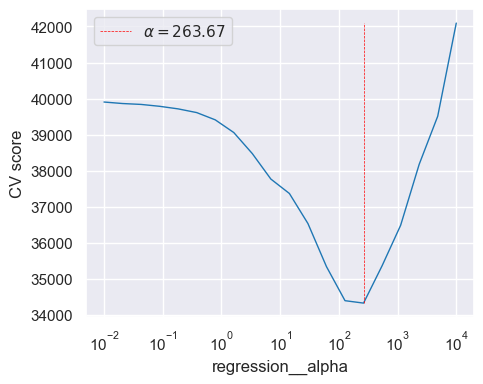

In [1451]:
best_alpha = bestAlpha(searcher)

In [1452]:
lasso_pipe, rmse_test, model = regPipeline(Lasso(best_alpha))

In [1453]:
rmse_test

25642.611

In [1454]:
np.sum(lasso_pipe.steps[-1][-1].coef_ == 0)

218

In [1455]:
np.sum(np.isclose(lasso_pipe.steps[-1][-1].coef_, 0))

218

Рассмотрим распределение остатков: построим гистограмму распределения квадратичной ошибки на обучающих объектах.

In [1456]:
residSq = lambda: np.square(y_train - model.predict(X_train))

plotResidHist = lambda resid2: sns.histplot(
    resid2, stat='density', bins=50, kde=True
)

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

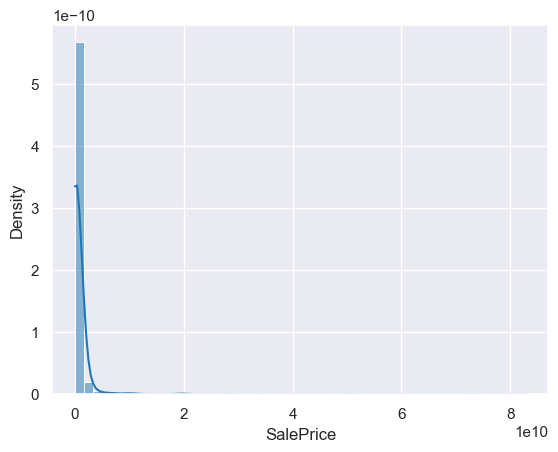

In [1457]:
resid2 = residSq()
plotResidHist(resid2)

Из гистограммы видно, что есть наблюдения с очень большими остатками. Выбросим из обучающей выборки те, остатки у которых больше $0.95$-квантили.

In [1458]:
keep = (resid2 < np.quantile(resid2, 0.95))
X_train, y_train = (subset[keep] for subset in (X_train, y_train))

In [1459]:
lasso_pipe, rmse_test, model = regPipeline(Lasso(best_alpha))

In [1460]:
rmse_test

24963.592

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

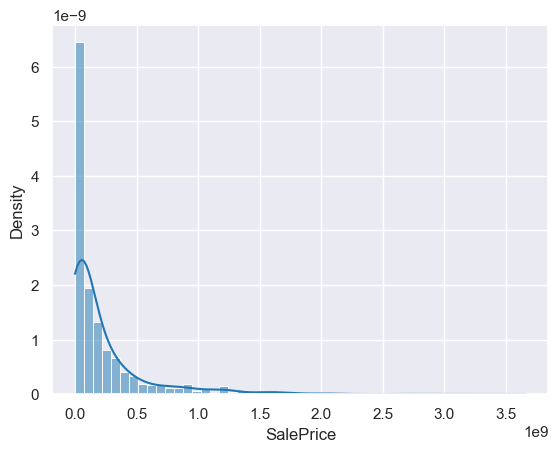

In [1461]:
plotResidHist(residSq())

***
### <a id='toc1_9_4_'></a>[__Часть 4. Подготовка данных для линейных моделей__](#toc0_)

Иногда качество модели можно улучшить разбиением признакового пространства на несколько областей и построения своей модели в каждой из них. Разделим выборку на две части по признаку __`OverallQual`__. Это один из самых сильных признаков, и, возможно, разбиение по нему даст нам две выборки с заведомо разными ценами на дома. Для начала вспомним, какое качество получается у обычной гребневой регрессии.

In [1462]:
ridge_pipe, rmse_test, _ = regPipeline(Ridge())

In [1463]:
rmse_test

23477.267

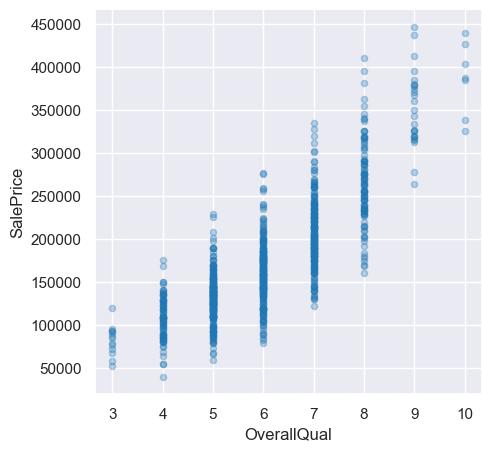

In [1464]:
plt.figure(figsize=(5,5))
plt.scatter(X_train.OverallQual, y_train, s=20, alpha=0.3)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

In [1465]:
threshold = 5
mask_train, mask_test = (subset.OverallQual <= threshold for subset in XSubsets)

X_train_sets, y_train_sets = ((subset[mask_train], subset[~mask_train]) 
                              for subset in (X_train, y_train))

train_sets = zip(X_train_sets, y_train_sets)

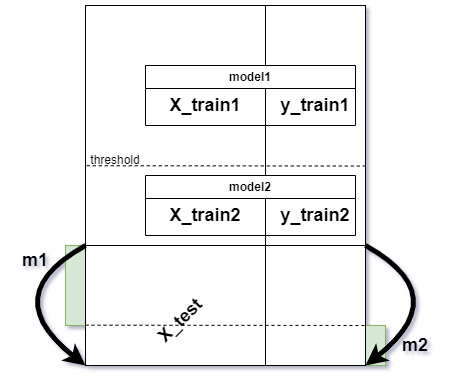

In [1466]:
pipe1 = regPipeline(Ridge())[0]
pipes = pipe1, clone(pipe1)  # https://bit.ly/429jp5X
models = (pipe.fit(*next(train_sets)) for pipe in pipes)

y_pred1, y_pred2 = (model.predict(X_test) for model in models)
y_pred1[~mask_test] = y_pred2[~mask_test]
rmse(y_test, y_pred1)

22665.953

Бинаризация признаков. Выберем $n$ порогов $t_1, \dots, t_n$ для признака $x_j$ и сгенерируем $n+1$ новый признак: $[x_j \leq t_1], [t_1 < x_j \leq t_2], \dots, [t_{n-1} < x_j \leq t_n], [x_j > t_n]$. Такое преобразование эффективно, если целевая переменная нелинейно зависит от одного из признаков. Рассмотрим синтетический пример.

In [1467]:
def columnnize(*arrs):
    return tuple(arr.reshape(-1,1) for arr in arrs)

In [1468]:
X = uniform.rvs(scale=1, **params)
y = np.cos(1.5 * np.pi * X) + noise
xplot = np.linspace(0, 1, 1001)
X_col, xplot_col = columnnize(X, xplot)

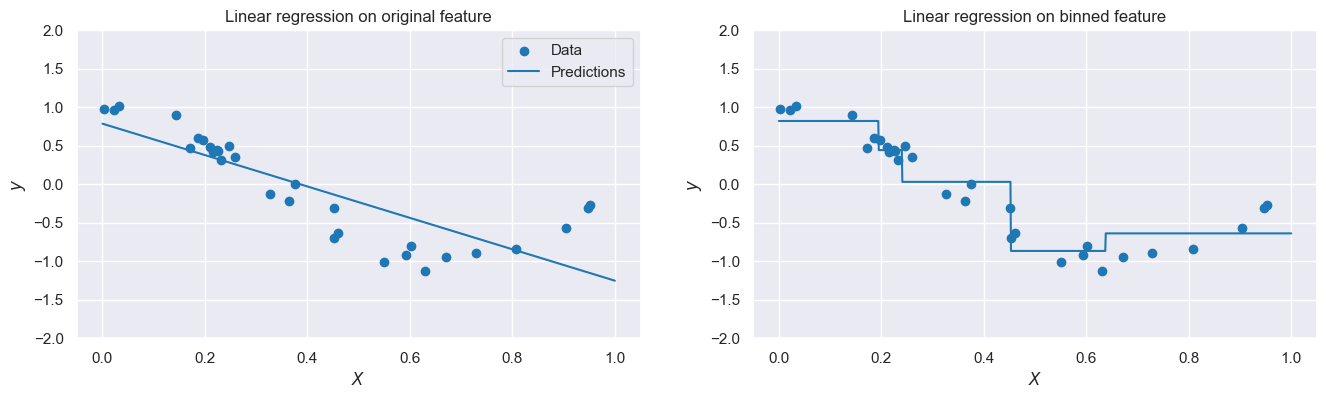

In [1469]:
fig, axs = plt.subplots(figsize=(16,4), ncols=2)

reg = LinearRegression()
reg.fit(X_col, y)
ypred_reg = reg.predict(xplot_col)
axs[0].scatter(X_col, y, label='Data')
axs[0].plot(xplot, ypred_reg, label='Predictions')
axs[0].set_ylim(-2,2)
axs[0].legend()
axs[0].set_xlabel('$X$')
axs[0].set_ylabel('$y$')
axs[0].set_title('Linear regression on original feature')

binner = KBinsDiscretizer(n_bins=5, strategy='quantile')
steps = {'binning': binner, 'regression': LinearRegression()}
pipe = Pipeline(steps.items())
pipe.fit(X_col, y)
ypred_bin = pipe.predict(xplot_col)
axs[1].scatter(X_col, y, label='Data')
axs[1].plot(xplot, ypred_bin, label='Predictions')
axs[1].set_ylim(-2,2)
axs[1].set_xlabel('$X$')
axs[1].set_ylabel('$y$')
axs[1].set_title('Linear regression on binned feature')

plt.show()

Качество модели выросло. Однако и увеличилось количество параметров модели из-за увеличения числа признаков. Поэтому при бинаризации важно контролировать переобучение.

Иногда может помочь преобразование целевой переменной. Может оказаться, что по мере роста признаков целевая переменная меняется экспоненциально. Например, может оказаться, что при линейном уменьшении продолжительности видео число его просмотров растет экспоненциально. Учесть это можно с помощью логарифмирования целевой переменной. Ниже синтетический пример такой ситуации.

In [1470]:
X = expon.rvs(1, **params)
y = np.exp(X) + noise
xplot = np.linspace(*describe(X).minmax, 1000)
X_col, xplot_col = columnnize(X, xplot)

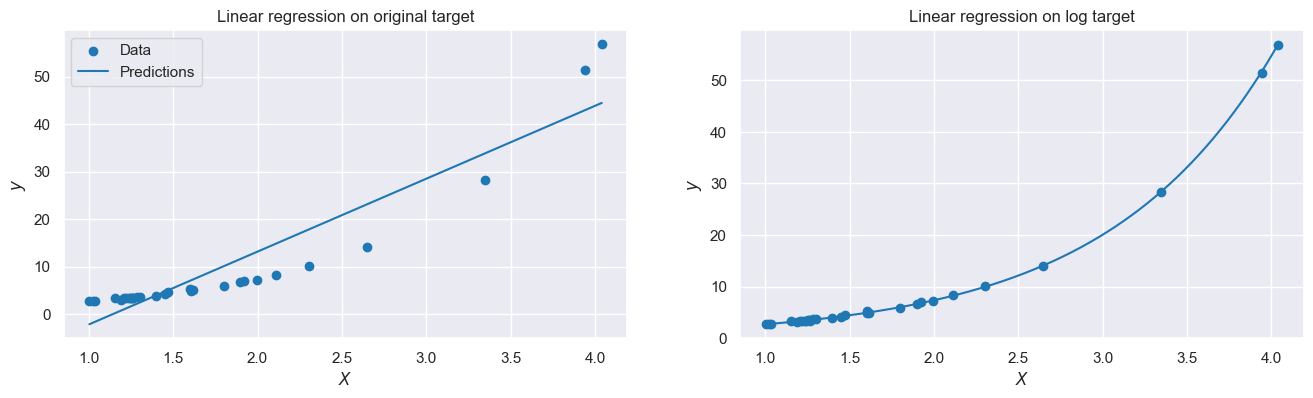

In [1471]:
fig, axs = plt.subplots(figsize=(16,4), ncols=2)

reg = LinearRegression()
reg.fit(X_col, y)
ypred_reg = reg.predict(xplot_col)
axs[0].scatter(X_col, y, label='Data')
axs[0].plot(xplot, ypred_reg, label='Predictions')
axs[0].legend()
axs[0].set_xlabel('$X$')
axs[0].set_ylabel('$y$')
axs[0].set_title('Linear regression on original target')

reg.fit(X_col, np.log(y))
ypred_log = np.exp(reg.predict(xplot_col))
axs[1].scatter(X_col, y, label='Data')
axs[1].plot(xplot, ypred_log, label='Predictions')
axs[1].set_title('Linear regression on log target')
axs[1].set_xlabel('$X$')
axs[1].set_ylabel('$y$')

plt.show()

Ниже пример с данными __`boston`__ по мотивам [__примера__](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html) из документации sklearn. Здесь используется несколько более сложное преобразование: вычисляются квантили распределения целевой переменной и квантили нормального распределения, после чего каждое значение целевой переменной переводится в значение, имеющее такую же квантиль у нормального распределения.

In [1472]:
boston = pd.read_csv('BostonHousing.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [1473]:
target = 'dis'
y = boston[target].values
X = boston.drop(columns=target).values

y_trans = quantile_transform(y.reshape(-1,1), n_quantiles=300, 
                             output_distribution='normal')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55)

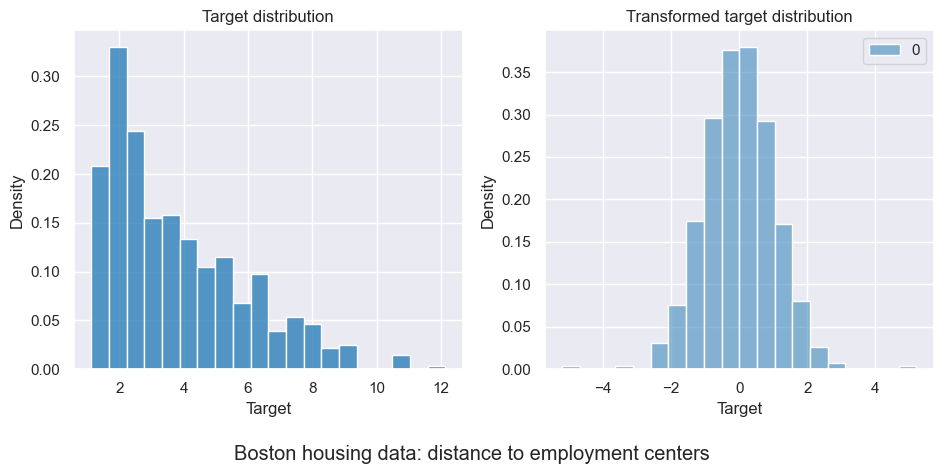

In [1474]:
titles = 'Target distribution', 'Transformed target distribution'
fig, axs = plt.subplots(1, 2, figsize=(10,5))

for n, target, title in zip(range(2), (y, y_trans), titles):
    sns.histplot(target, stat='density', bins=20, ax=axs[n])
    axs[n].set_xlabel('Target')
    axs[n].set_title(title)
    
fig.suptitle('Boston housing data: distance to employment centers', y=0)
fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

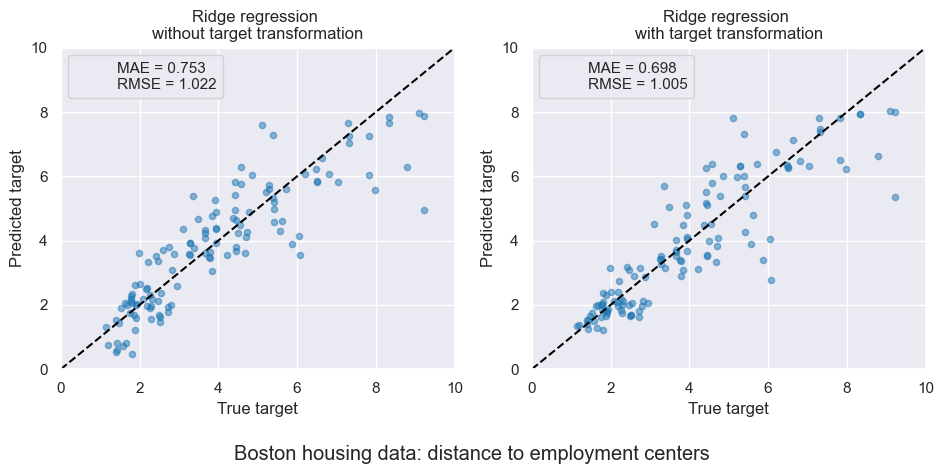

In [1475]:
qt = QuantileTransformer(n_quantiles=300, output_distribution='normal')
reg_trans = TransformedTargetRegressor(regressor=RidgeCV(), transformer=qt)

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for n, reg in enumerate([RidgeCV(), reg_trans]):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    axs[n].scatter(y_test, y_pred, s=20, alpha=0.5)
    axs[n].plot([0, 10], [0, 10], '--k')
    axs[n].set_xlim([0, 10])
    axs[n].set_ylim([0, 10])
    axs[n].set_ylabel('Predicted target')
    axs[n].set_xlabel('True target')
    axs[n].set_title(f"Ridge regression \nwith{('out', '')[n]} "
                     f"target transformation")
    axs[n].plot([], [], ' ', label=(f'MAE = {round(mae(y_test, y_pred), 3)}\n'
                                    f'RMSE = {rmse(y_test, y_pred)}'))
    axs[n].legend(loc='upper left')
    
fig.suptitle('Boston housing data: distance to employment centers', y=0)
fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

Преобразование целевой переменной дало улучшение, хоть и не значительное. При этом, как видно из графика, улучшения произошли в основном для небольших значений целевой переменной. Именно поэтому изменения больше заметны на MAE, чем на RMSE.